In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from util.evaluation import SMAPE
%matplotlib inline

traffic=pd.read_csv('../data/cl_traffic.csv')

traffic=traffic.fillna(0)

traffic.head()

sample_index=np.random.choice(traffic.index,40000,replace=False)
sample_series=[]
for u in sample_index:
#     print('Training...|| {:.2f}'.format(u/tot_len*100)+'%',end='\r')
    sample_series.append(traffic.loc[u][:-4].values)

def diff(x,epsilon=1e-3):
    return((x[1:]-x[:-1])/(x[:-1]+epsilon))

# combs=np.array([[0,0,0]])
# for series in range(len(sample_series)):
#     change=diff(sample_series[series][1:-2])
#     comb=np.array([change[1:-2],change[2:-1],change[3:]]).T
#     combs=np.concatenate((combs,comb),axis=0)

## prepare training data by discretize

In [32]:
def split_and_clean(sample_series,train_start,train_end,test_len):
    clean_series=[]
    test_series=[]
    for index in range(len(sample_series)):
        c=np.array(sample_series[index][train_start:train_end])
        test_series.append(sample_series[index][train_end:(train_end+test_len)])
        std=np.std(c)
        mean=np.mean(c)
        c[(c-np.mean(c))>2*std]=mean+2*std
        c[(c-np.mean(c))<-2*std]=mean-2*std
        clean_series.append(c)
    return (clean_series,test_series)

In [3]:
# plt.plot(clean_series[1])

In [4]:
def value2id(series,bin_size,biased_mean,std):
    id_series=np.array(list(map(lambda x:(x-biased_mean) // (std*bin_size),series)))
    id_series[id_series>(6/bin_size)]=(6/bin_size)
    id_series[id_series<0]=0
    return id_series

In [5]:
def id2value(id_series,bin_size,biased_mean,std):
    return id_series*(std*bin_size)+biased_mean

In [6]:
def discrify(clean_series):
    bin_size=0.005
    discrete_dic={}
    index_series=[]
    for i in range(len(clean_series)):
        if np.sum(clean_series[i])==0:
            std=-1
            biased_mean=-1
            discrete_dic[i]=(std,biased_mean)
            index_series.append(np.zeros_like(clean_series[i])+3/bin_size)
        else:
            std=np.std(clean_series[i])
            biased_mean=np.mean(clean_series[i])-3*std

            discrete_dic[i]=(std,biased_mean)
            index_series.append(value2id(clean_series[i],bin_size=bin_size,biased_mean=biased_mean,std=std))
    return (discrete_dic,index_series)

In [127]:
encode_start=0
encode_end=150
decode_len=10

clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)
discrete_dic,index_series = discrify(clean_series)

train_x=index_series
train_y=decode_series

encode_start=200
encode_end=350
decode_len=10


clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)
discrete_dic,index_series = discrify(clean_series)

test_x=index_series
test_y=decode_series

In [8]:
# for i in decode_series:
#     if sum(i[i>1199])>0:
#         print(i)

In [9]:
# changes=[]
# for series in range(len(sample_series)):
#     change=diff(sample_series[series][1:-2])
# #     change[change>2]=2
#     changes.append(change)

In [10]:
# changes=np.array(changes)

In [11]:
# changes.shape

In [12]:
# def num2index(num):
#     return int((num+1) // 0.0025)
# index
# def index2num(index):
#     return -1+(index+0.5)*0.0025

# index2num(1199)



In [13]:
# #discrete change
# dis_change=[]
# for i in range(len(changes)):
#     dis_change.append(list(map(lambda x:num2index(x),changes[i,:])))

In [14]:
# dis_change=np.array(dis_change)

In [15]:
# assert dis_change.shape==changes.shape

In [16]:
# train_x=dis_change[:,265:365]
# train_y=changes[:,365:365+63]
# test_x=dis_change[:,400:500]
# test_y=changes[:,500:500+63]

In [ ]:
def X_loader(x,batchsize=10):
    batch=0
    x=np.array(x)
    while batch<(len(x) // batchsize):
        
        data=x[batch*batchsize:(batch+1)*batchsize,:]
        yield(torch.LongTensor(np.array(data, dtype=int)).cuda())
        batch+=1

In [ ]:
def Y_loader(y,batchsize=10):
    batch=0
    y=np.array(y)
    while batch<(len(y) // batchsize):
        
        data=y[batch*batchsize:(batch+1)*batchsize,:]
        yield(torch.FloatTensor(np.array(data, dtype=float)).cuda())
        batch+=1

In [19]:
# changes[1,1:3]

In [130]:
import torch
import torch.nn as nn

class NN(nn.Module):
    def __init__(self, emb_dim,encoder_dim=150,out_dim=63, vocab_size=1200):
        super(NN, self).__init__()

        self.emb_dim = emb_dim
        self.embed = nn.Embedding(vocab_size, emb_dim)
        self.encoder = nn.GRU(emb_dim, encoder_dim, batch_first=True, bidirectional=False)
        self.decoder = nn.Linear(encoder_dim, out_dim)
    def forward(self, x):

        out = self.embed(x) 
#         print('embedding',out)
        output, hidden = self.encoder(out)
#         print('hidden',hidden)
        output = self.decoder(hidden)
        return output.squeeze()

In [131]:
model=NN(emb_dim=50,encoder_dim=25,out_dim=10,vocab_size=1201).cuda()

In [172]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data,param.grad.data)

AttributeError: 'NoneType' object has no attribute 'data'

In [174]:
def SMAPE(true,predicted):
    epsilon = 0.1
    summ = torch.abs(true) + torch.abs(predicted) + epsilon
    smape = torch.abs(predicted - true) / summ * 2.0
    return torch.mean(smape)

In [177]:
from torch import optim
epoch=15
indicator=200

model=NN(emb_dim=100,encoder_dim=50,out_dim=10,vocab_size=1201).cuda()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, \
    eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)

for i in range(epoch):
    trainx=X_loader(train_x)
    trainy=Y_loader(train_y)
    running_loss = 0.0
    validation(test_x,test_y)
    for j,X_batch in enumerate(trainx):
        #Parse loaded batch
        
        model.train()

        optimizer.zero_grad()
        output = model(X_batch)
        

        target=next(trainy)
        loss = SMAPE(target,output)

        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        optimizer.step()

        running_loss += loss.item()

        if (j>0) and (j % indicator == 0):
            print("Epoch: {}; iterations: {}; Loss: {}\n".format(i, j, running_loss / indicator))
            running_loss = 0.0
#             for name, param in model.named_parameters():
#                 if param.requires_grad:
#                     print (name, param.data,param.grad.data)
#             print(output)


VALIDATION: Epoch: 0; Loss: 1.9247453495889844

Epoch: 0; iterations: 200; Loss: 1.8336374229192733

Epoch: 0; iterations: 400; Loss: 1.622824536561966

Epoch: 0; iterations: 600; Loss: 1.5799700462818145

Epoch: 0; iterations: 800; Loss: 1.5227079963684083

Epoch: 0; iterations: 1000; Loss: 1.527059931755066

Epoch: 0; iterations: 1200; Loss: 1.5073617392778396

Epoch: 0; iterations: 1400; Loss: 1.4888217812776565

Epoch: 0; iterations: 1600; Loss: 1.484672139286995

Epoch: 0; iterations: 1800; Loss: 1.4929441317915917

Epoch: 0; iterations: 2000; Loss: 1.476705624461174

Epoch: 0; iterations: 2200; Loss: 1.4845084136724471

Epoch: 0; iterations: 2400; Loss: 1.463295203745365

Epoch: 0; iterations: 2600; Loss: 1.472944125533104

Epoch: 0; iterations: 2800; Loss: 1.4443435135483742

Epoch: 0; iterations: 3000; Loss: 1.4416085550189017

Epoch: 0; iterations: 3200; Loss: 1.448031479716301

Epoch: 0; iterations: 3400; Loss: 1.4546058464050293

Epoch: 0; iterations: 3600; Loss: 1.444813699

Epoch: 7; iterations: 2800; Loss: 1.2219722330570222

Epoch: 7; iterations: 3000; Loss: 1.2305418449640273

Epoch: 7; iterations: 3200; Loss: 1.2562976175546645

Epoch: 7; iterations: 3400; Loss: 1.2453119200468064

Epoch: 7; iterations: 3600; Loss: 1.2353793001174926

Epoch: 7; iterations: 3800; Loss: 1.2470121178030968

VALIDATION: Epoch: 8; Loss: 1.3203158203713194

Epoch: 8; iterations: 200; Loss: 1.250730659365654

Epoch: 8; iterations: 400; Loss: 1.221783173084259

Epoch: 8; iterations: 600; Loss: 1.2548389002680778

Epoch: 8; iterations: 800; Loss: 1.218719402551651

Epoch: 8; iterations: 1000; Loss: 1.260799520611763

Epoch: 8; iterations: 1200; Loss: 1.2465684649348259

Epoch: 8; iterations: 1400; Loss: 1.216506068110466

Epoch: 8; iterations: 1600; Loss: 1.2451998230814934

Epoch: 8; iterations: 1800; Loss: 1.2500730299949645

Epoch: 8; iterations: 2000; Loss: 1.2320285722613336

Epoch: 8; iterations: 2200; Loss: 1.246287516951561

Epoch: 8; iterations: 2400; Loss: 1.22511617

In [155]:
def validation(test_x,test_y):
    testx=X_loader(test_x)
    testy=Y_loader(test_y)
    running_loss = 0.0
    for j,X_batch in enumerate(testx):
        #Parse loaded batch
        
        model.eval()
        output = model(X_batch)
#         MSE = nn.MSELoss()
        target=next(testy)
        loss = SMAPE(target,output)
        running_loss += loss.item()
        print(j,end='\r')
        if j >500:
            break
    print("VALIDATION: Epoch: {}; Loss: {}\n".format(i, running_loss / j))


In [175]:
testx=X_loader(test_x)
testy=Y_loader(test_y)
running_loss = 0.0

preds=[]
targets=[]

scores=[]
for j,X_batch in enumerate(testx):
    #Parse loaded batch

    model.eval()
    output = model(X_batch)

    target=next(testy)
    loss = SMAPE(target,output)
    scores.append(loss.item())
    out=output.detach().cpu().numpy()
    target=target.detach().cpu().numpy()
    if j ==0:
        preds=out
        targets=target
    else:
        preds=np.concatenate((preds,out),axis=0)
        targets=np.concatenate((targets,target),axis=0)

In [176]:
np.mean(scores)

1.3006203021705152

In [134]:
len(preds)

40000

In [191]:
# def recover(start,change):
#     series=[]
#     last=start
#     for c in change:
#         last=last*(1+c)
#         series.append(last)
#     return series

In [160]:
def recover(ID,series,bin_size):
    std,biased_mean=discrete_dic[ID]
    series=series*(std*bin_size)+biased_mean
    return series

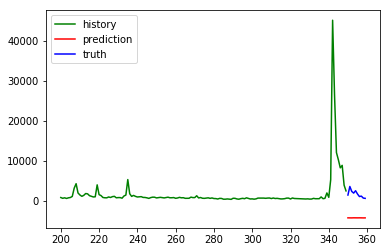

In [166]:
ID=100
source=sample_series[ID][encode_start:encode_end]
pred=recover(ID,preds[ID],0.005)
truth=targets[ID]

# for i in range(10):
plt.figure()
plt.plot(np.arange(encode_start,encode_end),source,color='g',label='history')
plt.plot(np.arange(encode_end,encode_end+decode_len),pred,color='r',label='prediction')
plt.plot(np.arange(encode_end,encode_end+decode_len),truth,color='b',label='truth')
plt.legend()

In [170]:
from util.evaluation import SMAPE
mean_scores=[]
for ID in range(4000):
    source=sample_series[ID][encode_start:encode_end]
    pred=recover(ID,preds[ID],0.005)
    truth=targets[ID]
    scores=[]
    for (t,p) in zip(truth,pred):
        scores.append(SMAPE(t,p))

    mean_scores.append(np.mean(scores))
np.mean(mean_scores)

1.6059648766305723